In [19]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np


# import seaborn as sns

# imports the Image module from the Python Imaging Library (PIL)
from PIL import Image
import cv2

# Split data
from sklearn.model_selection import train_test_split
# Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
# import keras
# Use transfer learning from EfficientNetB3 model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping
# Use preprocess input from EfficientNetB3, 
# because different model may need different preprocess/rescale
# The preprocess_input function applies the same normalization, 
# ensuring that your input images match the distribution expected by the model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [20]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [21]:
dataset_dir = '/kaggle/input/animals/animals/train'

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(dataset_dir)

horse: 2705
---------------
lion: 2675
---------------
dog: 2627
---------------
elephant: 2730
---------------
cat: 2737
---------------

Total: 13474


In [22]:
classes = os.listdir(dataset_dir)

# Collect all image file paths and labels
image_paths = []
label = []

for class_label in classes:
    class_folder = os.path.join(dataset_dir, class_label)
    for img_file in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img_file))
        label.append(class_label)

In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
labels_encoded = le.fit_transform(label)
labels_categorical = to_categorical(labels_encoded)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_categorical, test_size=0.2, stratify=labels_encoded, random_state=23
)


In [24]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def process_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = (train_ds
            .map(process_image, num_parallel_calls=AUTOTUNE)
            .shuffle(1024)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = (val_ds
          .map(process_image, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))


In [25]:
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(train_labels.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks=[early_stopping_cb]
)


Epoch 1/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 100s 175ms/step - accuracy: 0.8590 - loss: 0.4630 - val_accuracy: 0.9785 - val_loss: 0.0741
Epoch 2/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.9802 - loss: 0.0701 - val_accuracy: 0.9833 - val_loss: 0.0582
Epoch 3/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.9847 - loss: 0.0515 - val_accuracy: 0.9833 - val_loss: 0.0537
Epoch 4/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.9847 - loss: 0.0486 - val_accuracy: 0.9826 - val_loss: 0.0520
Epoch 5/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.9860 - loss: 0.0446 - val_accuracy: 0.9837 - val_loss: 0.0488
Epoch 6/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.9869 - loss: 0.0391 - val_accuracy: 0.9818 - val_loss: 0.0491
Epoch 7/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.9882 - loss: 0.0345 - val_accuracy: 0.9855 - val_loss: 0.0466
Epoch 8/70
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.9897 - loss: 0.0328 

In [27]:
model.save('/kaggle/working/animal_classifier.h5')


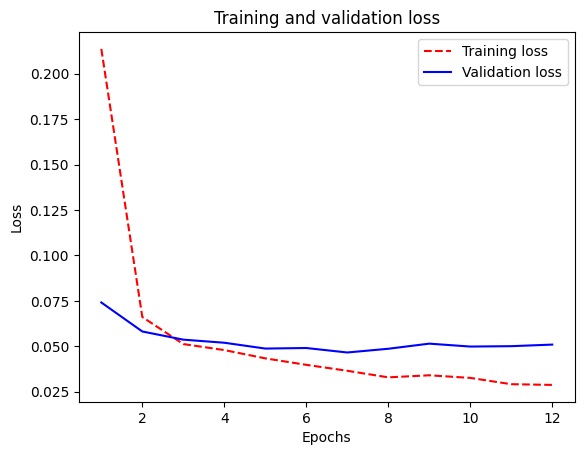

In [28]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

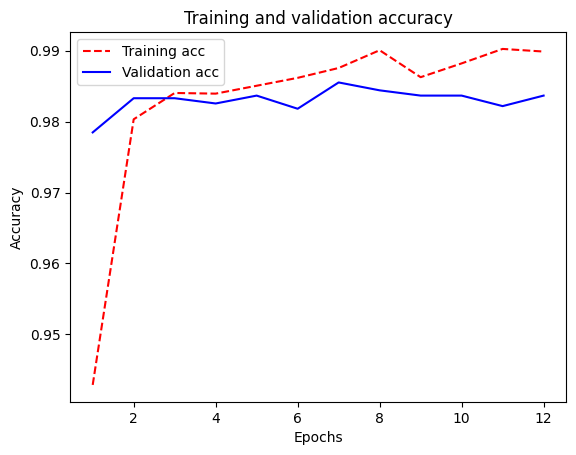

In [29]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [48]:
import numpy as np

# If you saved class_indices
# class_indices = np.load('class_indices.npy', allow_pickle=True).item()

# OR if you're still in the same session and used LabelEncoder:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(label)  # Same list used during training


LabelEncoder()

In [49]:
import tensorflow as tf

def load_and_prepare_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img


In [52]:
img = load_and_prepare_image("/kaggle/input/animals/animals/val/dog/dog10.jpg")
pred = model.predict(img)
predicted_class_idx = tf.argmax(pred, axis=1).numpy()[0]
predicted_class = le.inverse_transform([predicted_class_idx])[0]

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: dog


In [53]:
img = load_and_prepare_image("/kaggle/input/animals/animals/val/cat/cat10.jpg")
pred = model.predict(img)
predicted_class_idx = tf.argmax(pred, axis=1).numpy()[0]
predicted_class = le.inverse_transform([predicted_class_idx])[0]

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class: cat


In [54]:
img = load_and_prepare_image("/kaggle/input/animals/animals/val/lion/lion10.jpg")
pred = model.predict(img)
predicted_class_idx = tf.argmax(pred, axis=1).numpy()[0]
predicted_class = le.inverse_transform([predicted_class_idx])[0]

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: lion


In [55]:
img = load_and_prepare_image("/kaggle/input/animals/animals/val/elephant/elephant25.jpg")
pred = model.predict(img)
predicted_class_idx = tf.argmax(pred, axis=1).numpy()[0]
predicted_class = le.inverse_transform([predicted_class_idx])[0]

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: elephant
